In [1]:
import csv
import numpy as np

In [2]:
## import the matrix from co_occur.csv
Matrix = np.loadtxt(open("./co_occur.csv", "rb"), delimiter=",")
## import the word dict
with open('./dictionary.txt') as file:
    content = file.readlines()
word_dict = [x.strip() for x in content]
word_index = {}
for index, word in enumerate(word_dict):
    word_index[word] = index

### Sparse Vector Representation: PPMI 
Add 2 smooth PPMI

In [3]:
Matrix_pmi = Matrix + 2
Matrix_sum = np.sum(Matrix_pmi)

In [4]:
P_ij = (Matrix_pmi) / Matrix_sum
P_w = (np.sum(Matrix_pmi, axis = 1).reshape(Matrix_pmi.shape[0], 1)) / Matrix_sum 
P_c = (np.sum(Matrix_pmi, axis = 0).reshape(1, Matrix_pmi.shape[1])) / Matrix_sum 
pmi = np.log2(P_ij / np.dot(P_w, P_c))

In [5]:
pmi[pmi < 0] = 0

#### cosine similarity analysis

In [ ]:
np.vdot([2,0,0], [1,6,1])

In [6]:
def ppmi_cosine(str_input):
    idx = word_index[str_input]
    similarities = []
    input_norm = np.linalg.norm(pmi[idx,:])
    ## get the cosine value of input string with all other words 
    for j in range(pmi.shape[0]):
        similarities.append(np.vdot(pmi[idx,:], pmi[j,:]) / (input_norm * np.linalg.norm(pmi[j,:])))
    similarities_sorted = np.argsort(similarities)
    largest10 = similarities_sorted[-10 :]
    return largest10[::-1] 


In [7]:
output = ppmi_cosine('walk')
print(': ' + 'top 10 most similar: ')   
print([word_dict[index] for index in output])

: top 10 most similar: 
['walk', 'walking', 'walks', 'walked', 'climb', 'swim', 'ride', 'throw', 'sit', 'wait']


In [ ]:
def pmi_analogy_analysis(s1, s2, t1):
    existed = [s1,s2,t1]
    v_analogy = pmi[word_index[s2],:] - pmi[word_index[s1], :] + pmi[word_index[t1],:]
    similarities = []
    input_norm = np.linalg.norm(v_analogy)
    for j in range(pmi.shape[0]):
        similarities.append(np.vdot(v_analogy, pmi[j,:]) / (input_norm * np.linalg.norm(pmi[j,:])))
    similarities_sorted = np.argsort(similarities)
    largest10 = similarities_sorted[-10:]
    candidates = [word_dict[index] for index in largest10[::-1]]
    for candidate in candidates:
        if not (candidate in existed):
            return candidate
    return ''

In [ ]:
def analogy(s1, s2, t1):   
    output = pmi_analogy_analysis(s1, s2, t1)
    print('\'' + s1 + ' to ' + s2 + '\'' + ' is similar as ' + '\''+ t1 + ' to ' + output + '\'')

In [ ]:
analogy('man', 'woman', 'king')

In [ ]:
with open('./analogy_task.txt') as file:
    analogy_list = [[word.rstrip('\n') for word in line.split(' ')] for line in file]
count = 0
for analogy in analogy_list:
    output = pmi_analogy_analysis(analogy[0], analogy[1], analogy[2])
    if output == analogy[3]:
        count += 1
print('accuracy: ' + str(count / len(analogy_list)))

In [ ]:
len(analogy_list)

### Dense Vector Representation: SVD Analysis

In [8]:
M = np.log(1 + Matrix)
W, s, C = np.linalg.svd(M)

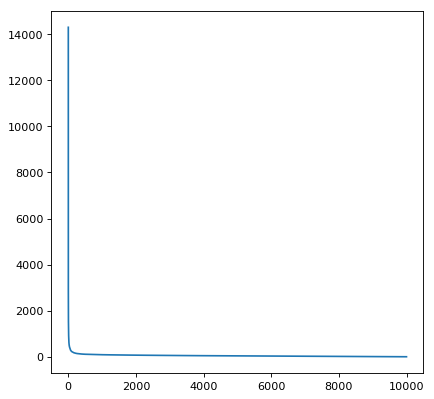

In [9]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (6,6), dpi = 80)
plt.plot(s.reshape(10000,1))
plt.show()

#### a low-rank approximation

In [10]:
s_k = np.diag(s[:100])
W_k = W[:,: 100]
C_k = C[: 100,:]
M_k = np.dot(np.dot(W_k, s_k), C_k)

In [ ]:
W_k.shape

W_k

In [ ]:
interested = [0,1,2,3,4]
for index in interested:
    vector = W[:, index]
    vector_sorted = np.argsort(vector)
    largest10 = vector_sorted[-10:]
    smallest10 = vector_sorted[:10]
    print('-' * 4 + "Vector " + str(index) + ':')
    print('top 10 most relevant: ' )   
    print([word_dict[index] for index in largest10[::-1]])
    print('top 10 least relevant:' )
    print([word_dict[index] for index in smallest10])

#### Normalization
we can regard the rows of W_normalized as word embeding 

In [11]:
l2norm_W = np.sqrt((W * W).sum(axis=1))
W_normalized =  W / l2norm_W.reshape(W.shape[0],1)

In [12]:
l2norm_Wk = np.sqrt((W_k * W_k).sum(axis=1))
Wk_normalized =  W_k / l2norm_Wk.reshape(W_k.shape[0],1)

In [ ]:
## 'woman'
v_woman = Wk_normalized[word_index['woman']]
## 'man'
v_man = Wk_normalized[word_index['man']]
## v1 - v2
v_wm = v_woman

In [ ]:
test_list = ['boy', 'girl', 'brother', 'sister', 'king', 'queen', 'he', 'she', 'john', 'mary', 'wall', 'tree']
project_list = []
for word in test_list:
    v_test = Wk_normalized[word_index[word]]
    projection = np.vdot(v_test, v_wm)
    project_list.append(projection)

import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,8), dpi = 80)
ax = fig.add_subplot(111)
plt.plot(project_list, 'ro')
for index, value in enumerate(project_list):
    ax.annotate('(%s, %s)' %(test_list[index],value), xy=(index,value), textcoords='data')
plt.show()

In [ ]:
test_list2 = ['math', 'history', 'nurse', 'doctor', 'pilot', 
             'teacher', 'engineer', 'science', 'arts', 'literature', 'bob', 'alice']
project_list2 = []
for word in test_list2:
    v_test = Wk_normalized[word_index[word]]
    project = np.vdot(v_test, v_wm)
    project_list2.append(project)

import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,8), dpi = 80)
ax = fig.add_subplot(111)

plt.plot(project_list2, 'bo')
for index, value in enumerate(project_list2):
    ax.annotate('(%s, %s)' %(test_list2[index],value), xy=(index, value), textcoords='data')
plt.show()

### similarity analysis

In [ ]:
Matrix_similarity = np.dot(Wk_normalized, Wk_normalized.transpose()) 

In [ ]:
index = word_index['good']
temp_vector = Matrix_similarity[index, :]
vector_sorted = np.argsort(temp_vector)
largest10 = vector_sorted[-10 :]
print(': ' + 'top 10 most similar:' + '-' * 4 )   
print([word_dict[index] for index in largest10[::-1]])

In [13]:
def svd_similar(str_input):
    index = word_index[str_input]
    similarities = []
    for j in range(Wk_normalized.shape[0]):
        similarities.append(np.vdot(Wk_normalized[index,:], Wk_normalized[j,:]))
    vector_sorted = np.argsort(similarities)
    largest10 = vector_sorted[-10 :]
    print(str_input +': ' + 'top 10 most similar:' + '-' * 4 )   
    print([word_dict[index] for index in largest10[::-1]])

In [14]:
svd_similar('sister')

sister: top 10 most similar:----
['sister', 'daughter', 'mother', 'wife', 'aunt', 'daughters', 'grandmother', 'niece', 'sisters', 'cousin']


#### “man is to woman as king is to __”

In [15]:
v_mwk = Wk_normalized[word_index['women'],:] - Wk_normalized[word_index['man'], :] + Wk_normalized[word_index['king'],:]
from scipy import spatial
tree = spatial.KDTree(Wk_normalized)
list_search = tree.query(v_mwk, k = 5)
print([word_dict[index] for index in list_search[1]])

['women', 'king', 'queen', 'crown', 'alexander']


In [27]:
## s1: france
## s2: paris
## t1: italy
from scipy import spatial
def analogy_analysis(s1, s2, t1):
    existed = [s1,s2,t1]
    v_analogy = Wk_normalized[word_index[s2],:] - Wk_normalized[word_index[s1], :] + Wk_normalized[word_index[t1],:]
    tree = spatial.KDTree(Wk_normalized)
    list_search = tree.query(v_analogy, k = 10)
    candidates = [word_dict[index] for index in list_search[1]]
    for candidate in candidates:
        if not (candidate in existed):
            return candidate
    print('no found')
    return ''

In [29]:
analogy_analysis('china', 'shanghai', 'thailand')

'bangkok'

In [30]:
with open('./analogy_task.txt') as file:
    analogy_list = [[word.rstrip('\n') for word in line.split(' ')] for line in file]
count = 0
for analogy in analogy_list:
    output = analogy_analysis(analogy[0], analogy[1], analogy[2])
    if output == analogy[3]:
        count += 1
print('accuracy: ' + str(count / len(analogy_list)))

accuracy: 0.5498657117278425
